In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

%matplotlib inline

In [2]:
from skimage import io  
from skimage import data

In [6]:
img = io.imread('../data/bead_pack_artifacts_small.tif')

In [ ]:
# uncomment if using Google colaboratory
#!wget https://github.com/dani-lbnl/imagexd19/blob/master/dip/data/bead_pack.tif?raw=true

In [ ]:
#!mv bead_pack.tif?raw=true bead_pack.tif

In [ ]:
#!ls *.tif

In [ ]:
#img = io.imread('bead_pack.tif')

# Basic image summary

In [23]:
print('* Shape: {}'.format(img.shape))
print('* Type: {}'.format(img.dtype))
print('* Range: {}, {}'.format(img.min(), img.max()))

* Shape: (200, 200, 200)
* Type: uint8
* Range: 29, 239


## Skim through

In [24]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

sub = 1 #change to larger number if image shape > 1k 

def slicer(z):
    plt.imshow(img[z,::sub,::sub], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=len(img),step=1,value=5));

interactive(children=(IntSlider(value=5, description='z', max=200), Output()), _dom_classes=('widget-interact'…

## Adjust exposure
- skimage.exposure.cumulative_distribution(image) 
- skimage.exposure.equalize(*args, **kwargs) 
- skimage.exposure.equalize_adapthist(image[, ...]) 
- skimage.exposure.equalize_hist(image[, nbins]) 
- skimage.exposure.histogram(image[, nbins]) 
- skimage.exposure.rescale_intensity(image[, ...]) 

In [25]:
from skimage import exposure
ex = exposure.equalize_hist(img)
def slicer(z):
    plt.imshow(ex[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

# Scipy ndimage
- Multi-dimensional image processing
- https://docs.scipy.org/doc/scipy/reference/ndimage.html

In [33]:
from skimage import morphology
ball = morphology.ball(radius=3)
ex = ndimage.median_filter(img,footprint=ball)

def slicer(z):
    plt.imshow(ex[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));


interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

## Edge detection


In [34]:
ball = morphology.ball(radius=3)
ex2 = ndimage.sobel(ex,-1)

def slicer(z):
    plt.imshow(ex2[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

In [35]:
from skimage import filters
img2 = filters.laplace(img)
def slicer(z):
    plt.imshow(img2[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

In [1]:
from skimage import filters
n=27
aslice = img[n,:,:]
filters.try_all_threshold(aslice,figsize=(16,10))

NameError: name 'img' is not defined

In [9]:
from skimage import filters
img3 = filters.gaussian(img)
t=filters.threshold_isodata(img3)
img3 = img3>t

def slicer(z):
    plt.imshow(img3[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

## <a id='morphology'></a>[skimage.morphology](https://scikit-image.org/docs/stable/api/skimage.morphology.html) - binary and grayscale morphology

Morphological image processing is a collection of non-linear operations related to the shape or morphology of features in an image, such as boundaries, skeletons, etc. In any given technique, we probe an image with a small shape or template called a structuring element, which defines the region of interest or neighborhood around a pixel.

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

There are a number of two and three dimensional structuring elements defined in `skimage.morphology`. Not all 2D structuring element have a 3D counterpart. The simplest and most commonly used structuring elements are the `disk`/`ball` and `square`/`cube`.

In [10]:
from skimage import morphology  # skimage's morphological submodules.

In [11]:
ball = morphology.ball(radius=3)

In [12]:
img2te=morphology.binary_erosion(img3,selem=ball)
img2to=morphology.binary_opening(img3,selem=ball)

In [13]:
#show two 2D images side by side for quick comparison
def imshowcmp(before,after,lut):
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(before,cmap=lut)
    ax[1].imshow(after,cmap=lut)

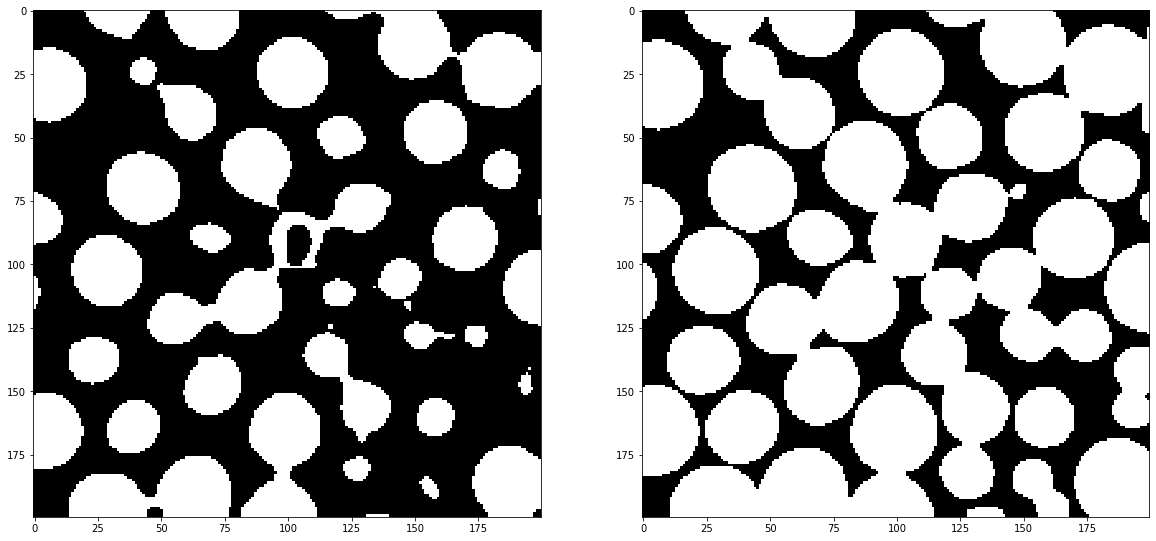

In [14]:
imshowcmp(img2te[n,:,:],img2to[n,:,:],'gray')

It's clear that we need to improve the segmentation before assigning different labels to disjoint regions as believed in the original sample.

Watershed segmentation can distinguish touching objects. Markers are placed at local minima and expanded outward until there is a collision with markers from another region. The inverse intensity image transforms bright cell regions into basins which should be filled.

In declumping, markers are generated from the distance function. Points furthest from an edge have the highest intensity and should be identified as markers using skimage.feature.peak_local_max. Regions with pinch points should be assigned multiple markers.

In [21]:
binary=morphology.binary_erosion(img2to,selem=ball)



In [ ]:
a = binary
def slicer(z):
    plt.imshow(a[z,:,:], cmap='gray')
interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

## Unsupervised classification - flood fill

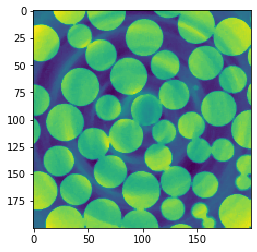

In [15]:
from skimage import segmentation as seg
b = filters.median(img[n,:,:])
plt.imshow(b)

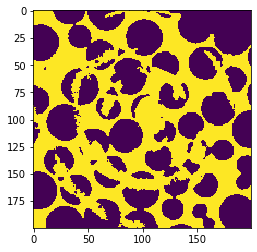

In [16]:
seed_point = (10, 10)  # Experiment with the seed point
c = seg.flood(b, seed_point, tolerance=50)
plt.imshow(c)

## Unsupervised - kmeans

In [17]:
from sklearn import cluster
kmeans_cluster = cluster.KMeans(n_clusters=50)
kmeans_cluster.fit(b)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

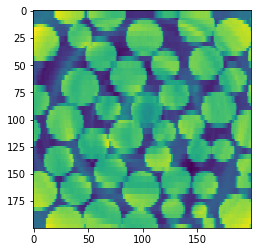

In [18]:
plt.imshow(cluster_centers[cluster_labels])

In [19]:
import itk
from itkwidgets import view

In [22]:
image_itk = itk.GetImageFromArray(binary.astype(np.uint8))
view(image_itk, cmap='Cold and Hot', slicing_planes=True,gradient_opacity=0.4)

Viewer(cmap='Cold and Hot', geometries=[], gradient_opacity=0.4, point_sets=[], rendered_image=<itkImagePython…

In [ ]:
from skimage import feature, measure

In [ ]:
label = measure.label(binary)
regions = measure.regionprops(label,intensity_image=img)

In [ ]:
np.max(label) #len(regionprops)

In [ ]:
#all_props = {p:regions[0][p] for p in regions[0] if p not in ('image','convex_image','filled_image')}
for p in regions:
    print(p.area)

In [ ]:
image_itk = itk.GetImageFromArray(label.astype(np.uint16))
view(image_itk, cmap='Cold and Hot', slicing_planes=True,gradient_opacity=0.4)

## How about some deep learning?

- Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. The model is the culmination of many ideas developed by multiple researchers over the years.
- Inception-v3 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is **48** layers deep and can classify images into **1000 object** categories, such as keyboard, mouse, pencil, and many animals.
- There are a total of 1,281,167 images for training. The number of images for each synset (category) ranges from 732 to 1300. There are 50,000 validation images, with 50 images per synset. There are 100,000 test images.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions

In [ ]:
net = InceptionV3()

**Why is it so fast?** We used transfer learning, a machine learning method which utilizes a pre-trained neural network. For example, the image recognition model called Inception-v3 consists of two parts: 
- Feature extraction part with a convolutional neural network;
- Classification part with fully-connected and softmax layers.

In [ ]:
from skimage import transform

def inception_predict(image):
    # Rescale image to 299x299, as required by InceptionV3
    image_prep = transform.resize(image, (299, 299, 3), mode='reflect')
    
    # Scale image values to [-1, 1], as required by InceptionV3
    image_prep = (img_as_float(image_prep) - 0.5) * 2
    
    predictions = decode_predictions(
        net.predict(image_prep[None, ...])
    )
    
    plt.imshow(image, cmap='gray')
    
    for pred in predictions[0]:
        (n, klass, prob) = pred
        print(f'{klass:>15} ({prob:.3f})')



In [ ]:
from skimage import data, img_as_float
inception_predict(data.chelsea())

In [ ]:
inception_predict(data.camera())